# Assingment 1 - MRI Contrast Classifier
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis (3RA023)


Welcome to the first course assignments! We provide a dataset based on the popular BraTS challenge (http://braintumorsegmentation.org/), containing MRI slices of the brain, of different contrasts (sometimes referred to as modalities): [T1-weighted](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging#T1_and_T2) (T1w), [T1-weighted with contrast agent](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging#Contrast_agents) (T1w-CE), [T2-weighted](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging#T1_and_T2) (T2w), and [FLAIR](https://en.wikipedia.org/wiki/Fluid-attenuated_inversion_recovery), also a manually delineated (segmented) binary maps of a [tumor](https://en.wikipedia.org/wiki/Brain_tumor), if visible on the slice.

The assignments will build on each other, and all three of them will use the same dataset and the same data generator so take your time to familiarize yourself with these.

In the first assignments you are tasked with training a *convolutional neural network* to classify the acquired MR data into their contrasts (T1w, T1w-CE, T2w, or FLAIR). Note that the network you develop here here will prove essential later in Assignment 3.

The code below is a working, but poor implementation of classifying between T1w and T2w contrasts. Your task is to expand and improve the code so that the final model handles all four contrasts, and achieves an accuracy of at least $95\%$. The most important aspect of the assignment is that all your choices in the final code are explained and supported in writing (in this notebook). Show your though process, even if you have managed to improve the accuracy by trial and error. Make sure that the Jupyter notebook you hand in includes:
- How you reached the required performances.
- Plot a [*confusion matrix*](https://en.wikipedia.org/wiki/Confusion_matrix) computed on the validation data, using your final model.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think were the biggest issues with the provided network and training, and how you solved them.

Upload the updated notebook to Canvas no later than **February $24^{th}$, 15:00**.

Good luck and have fun!

In [41]:
import os

import numpy as np
np.random.seed(2022)  # Set seed for reproducibility

import tensorflow as tf
tf.random.set_seed(2022)

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
import sklearn
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import matplotlib as mpl

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


In [2]:
gen_dir = "data/"  # Change if you have copied the data locally on your machine
array_labels = ['t1', 't1ce', 't2', 'flair']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.

In [3]:
class DataAugmentor:
    '''
    This class can be used to augment images. Augmentions possible are:
    - rotation around center of image
    - scale image
    - translate image
    - mirror the image
    '''
    def __init__(self, rot_prob = 0.0, translate_prob = 0.0, flip_prob = 0.0, scale_prob = 0.0):
        self.rot_prob = rot_prob
        self.translate_prob = translate_prob
        self.flip_prob = flip_prob
        self.scale_prob = scale_prob
        
    def rotate(self, probability):
        self.rot_ptob = probability
        
    def translate(self, probability):
        self.translate_prob = probability
        
    def flip(self, probability):
        self.flip_prob = probability
        
    def scale(self, probability):
        self.scale_prob = probability
    
    def augment_batch(self, batch):
        ret_images = []
        for image_class in batch:
            images = np.empty(image_class.shape).astype(np.single)
            for idx, image in enumerate(image_class):
                x = (image[:,:,0] * 255.0).astype(np.uint8)
                img = Image.fromarray(x)

                if np.random.uniform() < self.rot_prob:
                    deg = np.random.randint(5, 15)
                    sign = 1.0 if np.random.uniform() < 0.5 else -1.0
                    img = img.rotate(sign*deg)

                if np.random.uniform() < self.scale_prob:
                    scale_factor = np.random.uniform(1.0, 1.3)
                    img = ImageOps.scale(img, scale_factor)
                    crop_size = (img.width - x.shape[0]) / 2.0

                    img = ImageOps.crop(img, crop_size)

                if np.random.uniform() < self.flip_prob:
                    if np.random.uniform() < 0.5:
                        img = ImageOps.flip(img)
                        img = ImageOps.mirror(img)
                    else:
                        img = ImageOps.mirror(img)
                        img = ImageOps.flip(img)

                if np.random.uniform() < self.translate_prob:
                    delta = np.random.randint(-7, 7)
                    img = img.rotate(0.0, translate=(delta, delta))

                # get back our np array
                x = np.array(img).astype(np.single) / 255.0
                x = np.expand_dims(x, axis=2)
                images[idx, ] = x
            
            ret_images.append(images)

        return ret_images


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []
        
        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

In [5]:
# I increased the batch size a bit to speed things up
batch_size = 16

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? Their order will be the same as their unpacking order during training!
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

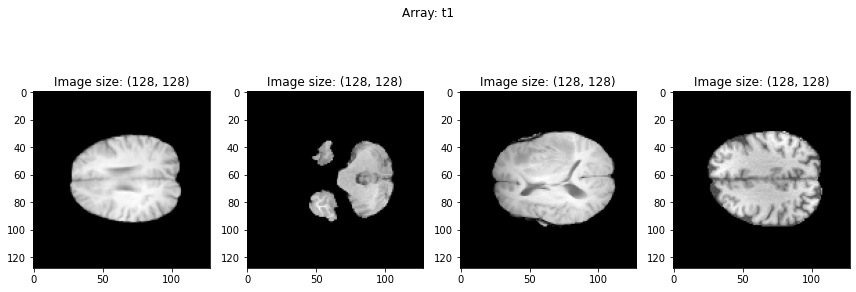

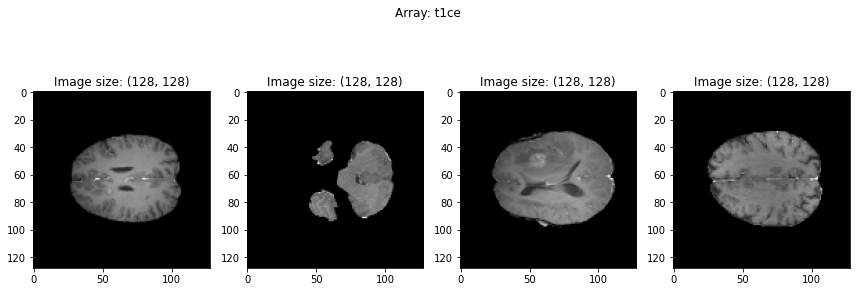

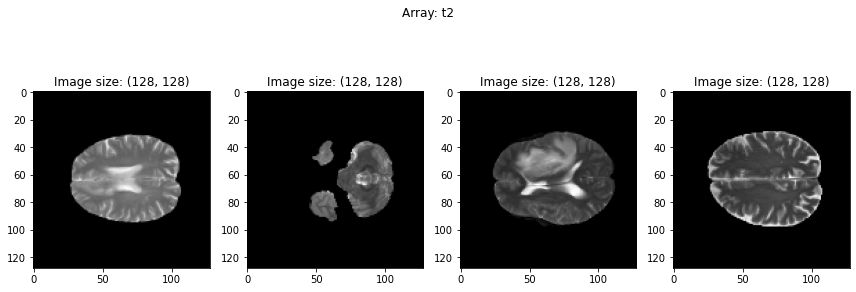

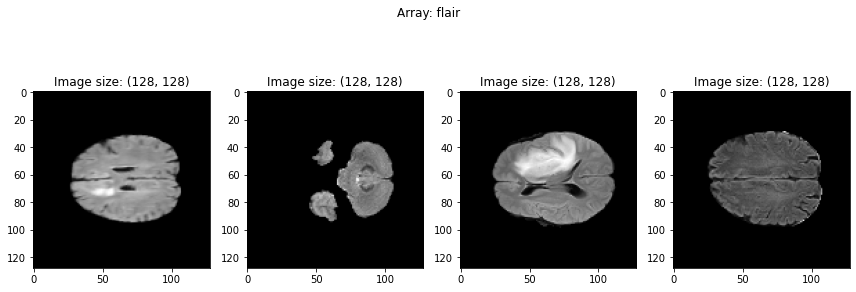

In [6]:
imgs = gen_train[0]
for inp in range(np.shape(imgs)[0]):
    plt.figure(figsize=(12,5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[inp][i, :, :, 0], cmap='gray')
        plt.title('Image size: ' + str(np.shape(imgs[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Array: ' + gen_train.arrays[inp])
    plt.show()

### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

A quick summery of the data sizes:

In [7]:
# A quick summary of the data:
print(f"Number of training images: {str(len(gen_train.file_list))}")
print(f"Training batch size      : {str(gen_train.in_dims)}")

Number of training images: 8000
Training batch size      : [(16, 128, 128, 1), (16, 128, 128, 1), (16, 128, 128, 1), (16, 128, 128, 1)]


In [8]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

# NOTE: Take inspiration from the imported layers and components, however you are not required to use all of them.

# Discussion and thoughts around my model

## How I reached the required performance?
Initially I found it very difficult to start with this task. I was unsure of what all the different layers did (apart from the dense layer) and how I would design the network. So, I started by googling the different layers, what they did. I found some very helpful resources, especially https://cs231n.github.io/convolutional-networks/. It provided a somewhat thorough understanding of convolutional layers and related layers such as pooling and normalization layers. More importantly, it also discusses common CNN architectures.

In [9]:
def build_model(height, width, channels):
    conv_reg_1 = tf.keras.regularizers.l2(0.001)
    conv_reg_2 = tf.keras.regularizers.l2(0.001)
    dense_reg = tf.keras.regularizers.l2(0.1)
    
    feature_extraction = [
        Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=conv_reg_1),
        Activation('relu'),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=conv_reg_1),
        Activation('relu'),

        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        
        Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=conv_reg_2),
        Activation('relu'),
        Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=conv_reg_2),
        Activation('relu'),

        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        #Dropout(0.25),
        
        Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Dropout(0.45),
        
        Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
        Activation('relu'),
        
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Dropout(0.45),

    ]
    
    classification = [
        Dense(256, kernel_regularizer=dense_reg),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(4, activation='softmax'),
    ]
    
    return Sequential(
        [Input(shape=(height, width, channels), name='input_1')] + 
        feature_extraction + 
        [Flatten()] + 
        classification
    )

# NOTE: A better designed network will improve performance. Look at the imported layers in the cell above for inspiration.

In [10]:
height, width, channels = gen_train.in_dims[0][1:]
model = build_model(height=height, width=width, channels=channels)
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

In [11]:
custom_lr = 0.0001
custom_optimizer = Adam(learning_rate=custom_lr)
custom_loss = tf.keras.losses.CategoricalCrossentropy()
custom_metric = "accuracy"

model.compile(loss=custom_loss,
              optimizer=custom_optimizer,
              metrics=[custom_metric])

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer? Look at the cell where the optimizers are imported for inspiration.
# NOTE: Are you satisfied with the optimizer's parameters?

In [12]:
n_epochs = 50
n_classes = 4
t1_label = tf.one_hot(np.repeat(0, batch_size), n_classes)
t1ce_label = tf.one_hot(np.repeat(1, batch_size), n_classes)
t2_label = tf.one_hot(np.repeat(2, batch_size), n_classes)
flair_label = tf.one_hot(np.repeat(3, batch_size), n_classes)

classification_labels = [t1_label, t1ce_label, t2_label, flair_label]

training_loss = []
training_acc = []
validation_loss = []
validation_acc = []

#augmentor = DataAugmentor(scale_prob=0.5, rot_prob=0.9, translate_prob=0.9, flip_prob=0.7)
augmentor = DataAugmentor()

for epoch in range(n_epochs):
    batch_training_loss = []
    batch_training_acc = []
    batch_validation_loss = []
    batch_validation_acc = []

    for idx, batch in enumerate(gen_train):
        (t1, t1ce, t2, flair) = augmentor.augment_batch(batch)
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        labels = np.concatenate((t1_label, t1ce_label, t2_label, flair_label), axis=0)
        
        indices = np.arange(images.shape[0])
        np.random.shuffle(indices)
        
        images = images[indices]
        labels = labels[indices]
        
        (loss, acc) = model.train_on_batch(images, labels)
        batch_training_loss.append(loss)
        batch_training_acc.append(acc)
    
    
    for idx, (t1, t1ce, t2, flair) in enumerate(gen_val):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        labels = np.concatenate((t1_label, t1ce_label, t2_label, flair_label), axis=0)
        test_results = model.test_on_batch(images, labels)

        batch_validation_loss.append(test_results[0])
        batch_validation_acc.append(test_results[1])
    
    t_loss = np.mean(batch_training_loss)
    t_acc = np.mean(batch_training_acc)
    
    v_loss = np.mean(batch_validation_loss)
    v_acc = np.mean(batch_validation_acc)
    
    print(f"Epoch: {epoch + 1:2d}, training loss: {t_loss:.3f}, training acc: {t_acc:.3f}, validation loss: {v_loss:.3f}, validation acc: {v_acc:.3f}")
    
    training_loss.append(t_loss)
    training_acc.append(t_acc)

    validation_loss.append(v_loss)
    validation_acc.append(v_acc)
    
    gen_train.on_epoch_end()
    
    if v_acc > 0.96:
        print(f"Got it at epoch {epoch + 1:2d}")
        break

Epoch:  1, training loss: 16.351, training acc: 0.605, validation loss: 4.160, validation acc: 0.689
Epoch:  2, training loss: 2.039, training acc: 0.861, validation loss: 1.268, validation acc: 0.861
Epoch:  3, training loss: 0.871, training acc: 0.922, validation loss: 0.979, validation acc: 0.841
Epoch:  4, training loss: 0.660, training acc: 0.940, validation loss: 0.911, validation acc: 0.853
Epoch:  5, training loss: 0.583, training acc: 0.954, validation loss: 0.732, validation acc: 0.887
Epoch:  6, training loss: 0.527, training acc: 0.964, validation loss: 0.784, validation acc: 0.881
Epoch:  7, training loss: 0.504, training acc: 0.970, validation loss: 0.679, validation acc: 0.916
Epoch:  8, training loss: 0.479, training acc: 0.972, validation loss: 0.614, validation acc: 0.942
Epoch:  9, training loss: 0.452, training acc: 0.978, validation loss: 0.724, validation acc: 0.898
Epoch: 10, training loss: 0.440, training acc: 0.979, validation loss: 0.773, validation acc: 0.885

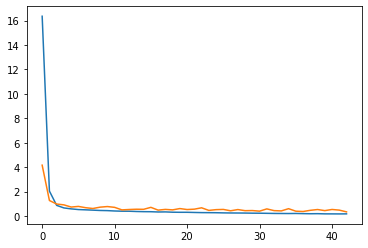

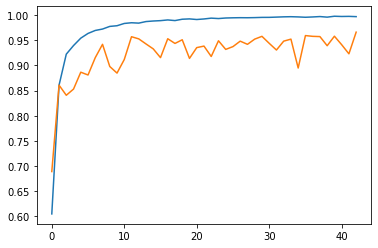

In [13]:
n_epochs = len(training_loss)
epoch_arr = np.arange(0, n_epochs)

plt.plot(epoch_arr, training_loss)
plt.plot(epoch_arr, validation_loss)
plt.show()

plt.plot(epoch_arr, training_acc)
plt.plot(epoch_arr, validation_acc)

In [14]:
# Utility function to extract the entire dataset of a generator
def get_full_dataset(generator):
    dims = generator.in_dims[0]
    full_labels = None
    full_inputs = None

    (t1, t1ce, t2, flair) = generator[0]
    full_inputs = np.concatenate((t1, t1ce, t2, flair), axis=0)
    full_labels = np.concatenate((t1_label, t1ce_label, t2_label, flair_label), axis=0)

    for idx, (t1, t1ce, t2, flair) in enumerate(generator):
        if idx == 0:
            continue
    
        a = np.concatenate((t1, t1ce, t2, flair), axis=0)
        full_inputs = np.concatenate((full_inputs, a), axis=0)
        a = np.concatenate((t1_label, t1ce_label, t2_label, flair_label), axis=0)
        full_labels = np.concatenate((full_labels, a), axis=0)
    
    return (full_inputs, full_labels)


In [15]:
full_inputs, full_labels = get_full_dataset(gen_val)
final_results = model.evaluate(full_inputs, full_labels)
print(final_results)

124/124 [==============================] - 1s 9ms/step - loss: 0.3369 - accuracy: 0.9662
[0.33687612414360046, 0.9662298560142517]


# Discussion around Confusion Matrix

As we can see from the confusion matrix below, the classifier had the most difficulty differentiating between t1 and t2 images, as well as between t1ce and flair images. This can be understood by noticing that the classifier missclassified a t1ce image as a t1 image 67 times, a t1 image was missclassified as a t1ce image 34 times and a flair image was missclassified as a t2 image 49 times. However, there was very little trouble classifying t2 images. This was interesting in my opinion as they are the images that is most easily mixed up by humans as well. I.e, they are the most alike.

(3968, 4)
tf.Tensor(
[[958  34   0   0]
 [ 67 918   7   0]
 [  0   3 989   0]
 [  4  18  49 921]], shape=(4, 4), dtype=int32)


C:\Users\bajs1\AppData\Local\Temp/ipykernel_21096/1091028176.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + array_labels)
C:\Users\bajs1\AppData\Local\Temp/ipykernel_21096/1091028176.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + array_labels)


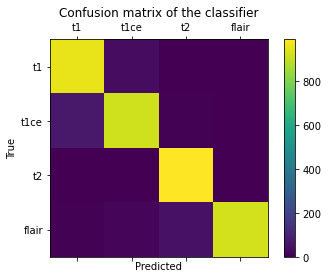

In [45]:
# Produce Confusion Matrix on the validation set
predictions = model.predict(full_inputs)
print(predictions.shape)
conf_mat = tf.math.confusion_matrix(full_labels.argmax(axis=1), predictions.argmax(axis=1))

print(conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + array_labels)
ax.set_yticklabels([''] + array_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
full_inputs, full_labels = get_full_dataset(gen_test)
test_results = model.evaluate(full_inputs,full_labels)
print(test_results)

124/124 [==============================] - 1s 11ms/step - loss: 0.3659 - accuracy: 0.9541
[0.36586806178092957, 0.9541330933570862]
